# Reinforcement Learning for Recommender Systems
## From Contextual Bandits to Slate-Q

<table>
<tr>
    <td> <img src="images/youtube.png" style="width: 230px;"/> </td>
    <td> <img src="images/dota2.jpg" style="width: 213px;"/> </td>
    <td> <img src="images/forklifts.jpg" style="width: 169px;"/> </td>
    <td> <img src="images/spotify.jpg" style="width: 254px;"/> </td>
    <td> <img src="images/robots.jpg" style="width: 252px;"/> </td>
</tr>
</table>


### Overview
“Reinforcement Learning for Recommender Systems, From Contextual Bandits to Slate-Q” is a tutorial for industry researchers, domain-experts, and ML-engineers, showcasing ...

1) .. how you can use RLlib to build a recommender system **simulator** for your industry applications and run Bandit algorithms and the Slate-Q algorithm against this simulator.

2) .. how RLlib's offline algorithms pose solutions in case you **don't have a simulator** of your problem environment at hand.

We will further explore how to deploy trained models to production using Ray Serve.

During the live-coding phases, we will using a recommender system simulating environment by google's RecSim and configure and run 2 RLlib algorithms against it. We'll also demonstrate how you may use offline RL as a solution for recommender systems and how to deploy a learned policy into production.

RLlib offers industry-grade scalability, a large list of algos to choose from (offline, model-based, model-free, etc..), support for TensorFlow and PyTorch, and a unified API for a variety of applications. This tutorial includes a brief introduction to provide an overview of concepts (e.g. why RL?) before proceeding to RLlib (recommender system) environments, neural network models, offline RL, student exercises, Q/A, and more. All code will be provided as .py files in a GitHub repo.

### Intended Audience
* Python programmers who are interested in using RL to solve their specific industry decision making problems and who want to get started with RLlib.

### Prerequisites
* Some Python programming experience.
* Some familiarity with machine learning.
* *Helpful, but not required:* Experience in reinforcement learning and Ray.
* *Helpful, but not required:* Experience with TensorFlow or PyTorch.

### Requirements/Dependencies

To get this very notebook up and running on your local machine, you can follow these steps here:

Install conda (https://www.anaconda.com/products/individual)

Then ...

#### Quick `conda` setup instructions (Linux):
```
$ conda create -n rllib_tutorial python=3.9
$ conda activate rllib_tutorial
$ pip install "ray[rllib,serve]" recsim jupyterlab tensorflow torch
```

#### Quick `conda` setup instructions (Mac):
```
$ conda create -n rllib_tutorial python=3.9
$ conda activate rllib_tutorial
$ pip install cmake "ray[rllib,serve]" recsim jupyterlab tensorflow torch
$ pip install grpcio # <- extra install only on apple M1 mac
$ # **Note:** In case you are getting a "requires TensorFlow version >= 2.8" error at some point in the notebook, try the following:
$ pip uninstall -y tensorflow
$ python -m pip install tensorflow-macos --no-cache-dir
```

#### Quick `conda` setup instructions (Win10):
```
$ conda create -n rllib_tutorial python=3.9
$ conda activate rllib_tutorial
$ pip install "ray[rllib,serve]" recsim jupyterlab tensorflow torch
$ pip install pywin32 # <- extra install only on Win10.
```

### Opening these tutorial files:
```
$ git clone https://github.com/sven1977/rllib_tutorials
$ cd rllib_tutorials/production_rl_2022
$ jupyter-lab
```


### Key Takeaways
* What is reinforcement learning and RLlib?
* How do recommender systems work? How do we build our own?
* How do we train RLlib's different algorithms on a recommender system problem?
* What's offline RL and how can I use it with RLlib?
* How do I deploy an already trained policy into production using Ray Serve.


### Tutorial Outline

1. Reinforcement learning (RL) in a nutshell.
1. How to formulate any problem as an RL-solvable one?
1. Recommender systems - How they work.
1. Why you should use RLlib.

(15min break)

1. [Google RecSim - Build your own recom sys simulator.](#recsim)
1. [Dissecting the "long term satisfaction" (LTE) environment.](#dissecting_lte)
1. [Using a contextual Bandit algorithm with RLlib and starting our first training run on the LTE env.](#rllib)
1. [What did the Bandit learn?](#bandit_results)
1. [Intro to Slate-Q.](#slateq)
1. [Starting a Slate-Q training run.](#slateq_experiment)

(15min break)

1. [Analyzing the results of the SlateQ run.](#slateq_results)
1. [Intro to Offline RL - What if we don't have an environment?](#offline_rl)
1. [BC (behavior cloning) and MARWIL: Quick how-to and setup instructions.](#bc_and_marwil)
1. [Off policy evaluation (OPE) as a means to estimate how well an offline-RL trained policy will perform in production.](#ope)
1. [Ray Serve example: How can we deploy a trained policy into our production environment?](#ray_serve)


### Other Recommended Readings
* [Intro to RLlib: Example Environments](https://medium.com/distributed-computing-with-ray/intro-to-rllib-example-environments-3a113f532c70)* [Reinforcement Learning with RLlib in the Unity Game Engine](https://medium.com/distributed-computing-with-ray/reinforcement-learning-with-rllib-in-the-unity-game-engine-1a98080a7c0d)

<img src="images/unity3d_blog_post.png" width=400>

* [Attention Nets and More with RLlib's Trajectory View API](https://medium.com/distributed-computing-with-ray/attention-nets-and-more-with-rllibs-trajectory-view-api-d326339a6e65)

# Let's start!

In [1]:
# Let's get started with some basic imports.

import ray  # .. of course
from ray import serve
from ray import tune

from collections import OrderedDict
import gym  # RL environments and action/observation spaces
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas
from pprint import pprint
import re
import recsim  # google's RecSim package.
import requests
from scipy.interpolate import make_interp_spline, BSpline
from scipy.stats import linregress, sem
from starlette.requests import Request
import tree  # dm_tree

!python --version
print(f"ray: {ray.__version__}")
import tensorflow as tf
print(f"tf: {tf.__version__}")
print("ok")

Python 3.9.12
ray: 1.12.0


/Users/christy/mambaforge/envs/rllib/lib/python3.9/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


tf: 2.7.0
ok


<a id='recsim'></a>
## Introducing google RecSim

<img src="images/recsim_documentation.png" width=600 style="float:right;">

<a href="https://github.com/google-research/recsim">Google's RecSim package</a> offers a flexible way for you to <a href="https://github.com/google-research/recsim/blob/master/recsim/colab/RecSim_Developing_an_Environment.ipynb">define the different building blocks of a recommender system</a>:


- User model (how do users change their preferences when having been faced with, selected, and consumed certain items?).
- Document model: Features of documents and how do documents get pre-selected/sampled.
- Reward functions.

RLlib comes with 3 off-the-shelf RecSim environments that are ready for training (with RLlib):
* Long Term Satisfaction (<- the "env" we will use in this tutorial)
* Interest Evolution
* Interest Exploration

<a id='dissecting_lte'></a>

In [2]:
# Import the built-in RecSim exapmle environment: "Long Term Satisfaction", ready to be trained by RLlib.
from ray.rllib.examples.env.recommender_system_envs_with_recsim import LongTermSatisfactionRecSimEnv

# Create a RecSim instance using the following config parameters (very similar to what we used above in our own recommender system env):
lts_10_1_env = LongTermSatisfactionRecSimEnv({
    "num_candidates": 10,  # action_sapce = Discrete(10) -> int 0-9
    "slate_size": 1,
    # Set to False for re-using the same candidate doecuments each timestep.
    "resample_documents": False,
    # Convert MultiDiscrete actions to Discrete (flatten action space).
    # e.g. slate_size=2 and num_candidates=10 -> MultiDiscrete([10, 10]) -> Discrete(100)  # 10x10
    "convert_to_discrete_action_space": True,
})

# What are our spaces?
#print(f"observation space = {lts_10_1_env.observation_space}")
print(f"action space = {lts_10_1_env.action_space}")

action space = Discrete(10)


Let's make use of our knowledge on the gym.Env API and call our new environment's `reset()` and `step()` methods.
First: `reset()` to receive the initial observation in a new episode/trajectory/session:

In [3]:
# Start a new episode and look at initial observation.
obs = lts_10_1_env.reset()
pprint(obs)

OrderedDict([('user', array([], dtype=float32)),
             ('doc',
              {'0': array([0.5488135], dtype=float32),
               '1': array([0.71518934], dtype=float32),
               '2': array([0.60276335], dtype=float32),
               '3': array([0.5448832], dtype=float32),
               '4': array([0.4236548], dtype=float32),
               '5': array([0.6458941], dtype=float32),
               '6': array([0.4375872], dtype=float32),
               '7': array([0.891773], dtype=float32),
               '8': array([0.96366274], dtype=float32),
               '9': array([0.3834415], dtype=float32)}),
             ('response',
              (OrderedDict([('click', 0),
                            ('engagement',
                             array(50.288185, dtype=float32))]),))])


Now let's play RL agent ourselves and recommend some items (pick some actions) via the environment's `step()` method:

**Task:** Execute the following cell a couple of times chosing different actions (from 0 - 9) to be sent into the environment's `step()` method. Each time, look at the returned next observation, reward, and `done` flag and write down what you find interesting about the dynamics and observations of this environment.

In [4]:
# Let's send our first action (1-slate back into the env) using the env's `step()` method.
action = 3  # Discrete(10): 0-9 are all valid actions

# This method returns 4 items:
# - next observation (after having applied the action)
# - reward (after having applied the action)
# - `done` flag; if True, the episode is terminated and the environment needs to be `reset()` again.
# - info dict (we'll ignore this)
next_obs, reward, done, _ = lts_10_1_env.step(action)

# Print out the next observation.
# We expect the "doc" and "user" items to be the same as in the previous observation
# b/c we set "resample_documents" to False.
pprint(next_obs)
# Print out rewards and the vlaue of the `done` flag.
print(f"reward = {reward:.2f}; done = {done}")


OrderedDict([('user', array([], dtype=float32)),
             ('doc',
              {'0': array([0.5488135], dtype=float32),
               '1': array([0.71518934], dtype=float32),
               '2': array([0.60276335], dtype=float32),
               '3': array([0.5448832], dtype=float32),
               '4': array([0.4236548], dtype=float32),
               '5': array([0.6458941], dtype=float32),
               '6': array([0.4375872], dtype=float32),
               '7': array([0.891773], dtype=float32),
               '8': array([0.96366274], dtype=float32),
               '9': array([0.3834415], dtype=float32)}),
             ('response',
              ({'click': 1, 'engagement': array(3.6387048, dtype=float32)},))])
reward = 3.64; done = False


<br />.<br />.<br />.<br />.<br />.
<br />.<br />.<br />.<br />.<br />.
<br />.<br />.<br />.<br />.<br />.
<br />.<br />.<br />.<br />.<br />.
<br />..<br />.<br />.<br />.<br />.


### What have we learnt from experimenting with the environment?

* User's state (if any) is hidden to agent (not part of observation).
* Episodes seem to last at least n timesteps -> user seems to have some time budget to spend.
* User always seems to click, no matter what we recommend.
* Reward seems to be always identical to the "engagement" value (of the clicked item). These values range somewhere between 0.0 and 20.0+.
* Weak suspicion: If we always recommend the item with the highest feature value, rewards seem to taper off over time - in most of the episodes.
* Weak suspicion: If we always recommend the item with the lowest feature value, rewards seem to increase over time.

### What the environment actually does under the hood

Let's take a quick look at a pre-configured RecSim environment: "Long Term Satisfaction".

<img src="images/long_term_satisfaction_env.png" width=1200>

Now that we know, that there is a double objective built into the env (a. sweetness -> engagement; b. sweetness -> unhappyness; unhappyness -> low engagement), let's make this effect a tiny bit stronger by slightly modifying the environment. As said above, the effect is very weak and almost not measurable, which is a problem on the env's side. We can use this following `gym.ObservationWrapper` class in the cell below to "fix" that problem:

In [5]:
# Modifying wrapper around the LTS (Long Term Satisfaction) env:
# - allows us to tweak the user model (and thus: reward behavior)
# - adds user's current satisfaction value to observation

class LTSWithStrongerDissatisfactionEffect(gym.ObservationWrapper):

    def __init__(self, env):
        # Tweak incoming environment.
        env.environment._user_model._user_sampler._state_parameters.update({
            "sensitivity": 0.058,
            "time_budget": 120,
            "choc_stddev": 0.1,
            "kale_stddev": 0.1,
            #"innovation_stddev": 0.01,
            #"choc_mean": 1.25,
            #"kale_mean": 1.0,
            #"memory_discount": 0.9,
        })

        super().__init__(env)

        # Adjust observation space.
        if "response" in self.observation_space.spaces:
            self.observation_space.spaces["user"] = gym.spaces.Box(0.0, 1.0, (1, ), dtype=np.float32)
            for r in self.observation_space["response"]:
                if "engagement" in r.spaces:
                    r.spaces["watch_time"] = r.spaces["engagement"]
                    del r.spaces["engagement"]
                    break

    def observation(self, observation):
        if "response" in self.observation_space.spaces:
            observation["user"] = np.array([self.env.environment._user_model._user_state.satisfaction])
            for r in observation["response"]:
                if "engagement" in r:
                    r["watch_time"] = r["engagement"]
                    del r["engagement"]
        return observation


# Add the wrapping around 
tune.register_env("modified_lts", lambda env_config: LTSWithStrongerDissatisfactionEffect(LongTermSatisfactionRecSimEnv(env_config)))

print("ok; registered the string 'modified_lts' to be used in RLlib configs (see below)")

ok; registered the string 'modified_lts' to be used in RLlib configs (see below)


Now that we have a stronger effect of the user's satisfaction value on the long-term rewards, we may be able to measure this effect reliably
using the following utility code:

In [6]:
# This cell should help you with your own analysis of the two above "suspicions":
# Always chosing the highest/lowest-valued action will lead to a decrease/increase in rewards over the course of an episode.
modified_lts_10_1_env = LTSWithStrongerDissatisfactionEffect(lts_10_1_env)

# Capture slopes of all trendlines over all episodes.
slopes = []
# Run 1000 episodes.
for _ in range(1000):
    obs = modified_lts_10_1_env.reset()  # Reset environment to get initial observation:

    # Compute actions that pick doc with highest/lowest feature value.
    action_sweetest = np.argmax([value for _, value in obs["doc"].items()])
    action_kaleiest = np.argmin([value for _, value in obs["doc"].items()])

    # Play one episode.
    done = False
    rewards = []
    while not done:
        #action = action_sweetest
        action = action_kaleiest
        #action = np.random.choice([action_kaleiest, action_sweetest])

        obs, reward, done, _ = modified_lts_10_1_env.step(action)
        rewards.append(reward)

    # Create linear model of rewards over time.
    reward_linreg = linregress(np.array((range(len(rewards)))), np.array(rewards))
    slopes.append(reward_linreg.slope)

print(np.mean(slopes))

0.0007349420303810714


## Measuring random baseline of our environment

In the cells above, we created a new environment instance (`lts_10_1_env`). As we have seen above, in order to start "walking" through a recommender system episode, we need to perform `reset()` and then several `step()` calls (with different actions) until the returned `done` flag is True.

Let's find out how well a randomly acting agent performs in this environment:

In [7]:
# Function that measures and outputs the random baseline reward.
# This is the expected accumulated reward per episode, if we act randomly (recommend random items) at each time step.
def measure_random_performance_for_env(env, episodes=1000, verbose=False):

    # Reset the env.
    env.reset()

    # Number of episodes already done.
    num_episodes = 0
    # Current episode's accumulated reward.
    episode_reward = 0.0
    # Collect all episode rewards here to be able to calculate a random baseline reward.
    episode_rewards = []

    # Enter while loop (to step through the episode).
    while num_episodes < episodes:
        # Produce a random action.
        action = env.action_space.sample()

        # Send the action to the env's `step()` method to receive: obs, reward, done, and info.
        obs, reward, done, _ = env.step(action)
        episode_reward += reward

        # Check, whether the episde is done, if yes, reset and increase episode counter.
        if done:
            if verbose:
                print(f"Episode done - accumulated reward={episode_reward}")
            elif num_episodes % 100 == 0:
                print(f" {num_episodes} ", end="")
            elif num_episodes % 10 == 0:
                print(".", end="")
            num_episodes += 1
            env.reset()
            episode_rewards.append(episode_reward)
            episode_reward = 0.0

    # Print out and return mean episode reward (and standard error of the mean).
    env_mean_random_reward = np.mean(episode_rewards)

    print(f"\n\nMean episode reward when acting randomly: {env_mean_random_reward:.2f}+/-{sem(episode_rewards):.2f}")

    return env_mean_random_reward, sem(episode_rewards)


In [8]:
%time
# Let's create a somewhat tougher version of this with 20 candidates (instead of 10) and a slate-size of 2.
# We'll also keep using our wrapper from above to strengthen the dissatisfaction effect on the engagement:
lts_20_2_env = LTSWithStrongerDissatisfactionEffect(LongTermSatisfactionRecSimEnv(config={
    "num_candidates": 20,
    "slate_size": 2,  # MultiDiscrete([20, 20]) -> Discrete(400)
    "resample_documents": True,
    # Convert to Discrete action space.
    "convert_to_discrete_action_space": True,
    # Wrap observations for RLlib bandit: Only changes dict keys ("item" instead of "doc").
    "wrap_for_bandits": True,
}))

lts_20_2_env_mean_random_reward, _ = measure_random_performance_for_env(lts_20_2_env, episodes=1000)

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 3.1 µs
 0 ......... 100 ......... 200 ......... 300 ......... 400 ......... 500 ......... 600 ......... 700 ......... 800 ......... 900 .........

Mean episode reward when acting randomly: 1158.06+/-0.36


# Plugging in RLlib
<a id='rllib'></a>

## Picking an RLlib algorithm ("Trainer")

https://docs.ray.io/en/master/rllib-algorithms.html#available-algorithms-overview

<img src="images/rllib_algorithms_bandits.png">

### Trying a "Contextual n-armed Bandit" on our environment

In [9]:
# In order to use one of the above algorithms, you may instantiate its associated Trainer class.
# For example, to import a Bandit Trainer w/ Upper Confidence Bound (UCB) exploration, do:

from ray.rllib.agents.bandit import BanditLinUCBTrainer

In [10]:
# Configuration dicts for RLlib Trainers.
# Where are the default configuration dicts stored?

# E.g. Bandit algorithms:
from ray.rllib.agents.bandit.bandit import DEFAULT_CONFIG as BANDIT_DEFAULT_CONFIG
print(f"Bandit's default config is:")
pprint(BANDIT_DEFAULT_CONFIG)

# DQN algorithm:
#from ray.rllib.agents.dqn import DEFAULT_CONFIG as DQN_DEFAULT_CONFIG
#print(f"DQN's default config is:")
#pprint(DQN_DEFAULT_CONFIG)

# Common (all algorithms).
#from ray.rllib.agents.trainer import COMMON_CONFIG
#print(f"RLlib Trainer's default config is:")
#pprint(COMMON_CONFIG)

Bandit's default config is:
{'_disable_action_flattening': False,
 '_disable_execution_plan_api': False,
 '_disable_preprocessor_api': False,
 '_fake_gpus': False,
 '_tf_policy_handles_more_than_one_loss': False,
 'action_space': None,
 'actions_in_input_normalized': False,
 'always_attach_evaluation_results': False,
 'batch_mode': 'truncate_episodes',
 'callbacks': <class 'ray.rllib.agents.callbacks.DefaultCallbacks'>,
 'clip_actions': False,
 'clip_rewards': None,
 'collect_metrics_timeout': -1,
 'compress_observations': False,
 'create_env_on_driver': False,
 'custom_eval_function': None,
 'custom_resources_per_worker': {},
 'disable_env_checking': False,
 'eager_max_retraces': 20,
 'eager_tracing': False,
 'env': None,
 'env_config': {},
 'env_task_fn': None,
 'evaluation_config': {},
 'evaluation_duration': 10,
 'evaluation_duration_unit': 'episodes',
 'evaluation_interval': None,
 'evaluation_num_episodes': -1,
 'evaluation_num_workers': 0,
 'evaluation_parallel_to_training': Fal

In [11]:
bandit_config = {
    "env": "modified_lts",
    "env_config": {
        "num_candidates": 20,  # 20x19 = ~400 unique slates (arms)
        "slate_size": 2,
        "resample_documents": True,

        # Bandit-specific flags:
        "convert_to_discrete_action_space": True,
        # Convert "doc" key into "item" key.
        "wrap_for_bandits": True,
        # Use consistent seeds for the environment ...
        "seed": 0,
    },
    # ... and the Trainer itself.
    "seed": 0,

    # The following settings are affecting the reporting only:
    # ---
    # Generate a result dict every single time step.
    "timesteps_per_iteration": 1,
    # Report rewards as smoothed mean over this many episodes.
    "metrics_num_episodes_for_smoothing": 200,
}

# Create the RLlib Trainer using above config.
bandit_trainer = BanditLinUCBTrainer(config=bandit_config)
bandit_trainer

2022-04-17 17:24:39,724	WARNING rollout_worker.py:498 -- We've added a module for checking environments that are used in experiments. It will cause your environment to fail if your environment is not set upcorrectly. You can disable check env by setting `disable_env_checking` to True in your experiment config dictionary. You can run the environment checking module standalone by calling ray.rllib.utils.check_env(env).
2022-04-17 17:24:39,725	WARNING env.py:120 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.


BanditLinUCBTrainer

#### Running a single training iteration, by calling the `.train()` method:

One iteration for most algos involves:

1. Sampling from the environment(s)
1. Using the sampled data (observations, actions taken, rewards) to update the policy model (e.g. a neural network), such that it would pick better actions in the future, leading to higher rewards.

Let's try it out:

In [12]:
# Perform single `.train()` call.
result = bandit_trainer.train()
# Erase config dict from result (for better overview).
del result["config"]
# Print out training iteration results.
pprint(result)

2022-04-17 17:24:39,755	WARNING bandit_torch_policy.py:48 -- The env did not report `regret` values in its `info` return, ignoring.


{'agent_timesteps_total': 1,
 'custom_metrics': {},
 'date': '2022-04-17_17-24-39',
 'done': False,
 'episode_len_mean': nan,
 'episode_media': {},
 'episode_reward_max': nan,
 'episode_reward_mean': nan,
 'episode_reward_min': nan,
 'episodes_this_iter': 0,
 'episodes_total': 0,
 'experiment_id': 'b81a3a2a0a284a54b6c9c19fe366ef44',
 'hist_stats': {'episode_lengths': [], 'episode_reward': []},
 'hostname': 'Christys-MacBook-Pro.local',
 'info': {'learner': {'default_policy': {'learner_stats': {'update_latency': 0.0008311271667480469}}},
          'num_agent_steps_sampled': 1,
          'num_agent_steps_trained': 1,
          'num_steps_sampled': 1,
          'num_steps_trained': 1,
          'num_steps_trained_this_iter': 1},
 'iterations_since_restore': 1,
 'node_ip': '127.0.0.1',
 'num_healthy_workers': 0,
 'off_policy_estimator': {},
 'perf': {'cpu_util_percent': 23.6, 'ram_util_percent': 68.0},
 'pid': 98498,
 'policy_reward_max': {},
 'policy_reward_mean': {},
 'policy_reward_min'

 0 .... 500 .... 1000 .... 1500 .... 2000 .... 2500 ....

/var/folders/0g/jfs_l_113_356_c0rfp4jd8c0000gn/T/ipykernel_98498/4138643203.py:20: RuntimeWarning: Mean of empty slice
  y = [np.nanmean(rewards[max(i - smoothing_win, 0):i + 1]) for i in range(start_at, len(rewards))]


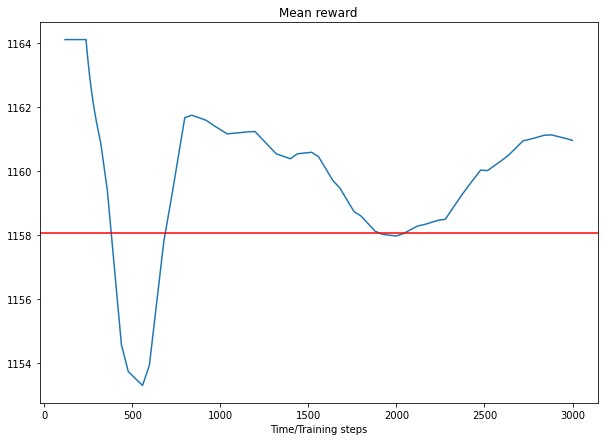

In [13]:
# Train for n more iterations (timesteps) and collect n-arm rewards.
rewards = []
for i in range(3000):
    # Run a single timestep in the environment and update
    # the model immediately on the received reward.
    result = bandit_trainer.train()
    # Extract reward from results.
    #rewards.extend(result["hist_stats"]["episode_reward"]
    rewards.append(result["episode_reward_mean"])
    if i % 500 == 0:
        print(f" {i} ", end="")
    elif i % 100 == 0:
        print(".", end="")

# Plot per-timestep (episode) rewards.
plt.figure(figsize=(10,7))
start_at = 0
smoothing_win = 200
x = list(range(start_at, len(rewards)))
y = [np.nanmean(rewards[max(i - smoothing_win, 0):i + 1]) for i in range(start_at, len(rewards))]
plt.plot(x, y)
plt.title("Mean reward")
plt.xlabel("Time/Training steps")

# Add mean random baseline reward (red line).
plt.axhline(y=lts_20_2_env_mean_random_reward, color="r", linestyle="-")

plt.show()

<a id='bandit_results'></a>
### What does our trained Bandit actually recommend?

The first method of the RLlib Trainer API we used above was `train()`.
We'll now use another method of the Trainer, `compute_single_action(input_dict={})`.
It takes a input_dict keyword arg, into which you may pass a single (unbatched!) observation to receive an action for:

In [14]:
# Let's see what items our bandit recommends now that it has been trained and achieves good (>> random) rewards.
obs = lts_20_2_env.reset()

# Run a single episode.
done = False
while not done:
    # Pass the single (unbatched) observation into the `compute_single_action` method of our Trainer.
    # This is one way to perform inference on a learned policy.
    action = bandit_trainer.compute_single_action(input_dict={"obs": obs})
    feat_value_of_action = obs["item"][action][0]
    max_choc_feat = obs['item'][np.argmax(obs["item"])][0]

    # Print out the picked document's feature value and compare that to the highest possible feature value.
    print(f"action's feature value={feat_value_of_action}; max-choc-feature={max_choc_feat}; ")

    # Apply the computed action in the environment and continue.
    obs, r, done, _ = lts_20_2_env.step(action)


action's feature value=0.8916457295417786; max-choc-feature=0.8916457295417786; 
action's feature value=0.9777311682701111; max-choc-feature=0.9777311682701111; 
action's feature value=0.9989755749702454; max-choc-feature=0.9989755749702454; 
action's feature value=0.8999373912811279; max-choc-feature=0.8999373912811279; 
action's feature value=0.9658776521682739; max-choc-feature=0.9658776521682739; 
action's feature value=0.9644351601600647; max-choc-feature=0.9644351601600647; 
action's feature value=0.9434471726417542; max-choc-feature=0.9434471726417542; 
action's feature value=0.974498987197876; max-choc-feature=0.974498987197876; 
action's feature value=0.9987043142318726; max-choc-feature=0.9987043142318726; 
action's feature value=0.9603764414787292; max-choc-feature=0.9603764414787292; 
action's feature value=0.9986302256584167; max-choc-feature=0.9986302256584167; 
action's feature value=0.9272821545600891; max-choc-feature=0.9272821545600891; 
action's feature value=0.95504

### Ok, Bandits want Chocolate! :)
#### Why is that?

<img src="images/contextual_bandit.png" width=1000>

### Recap: Advantages and Disatvantages of Bandits:
#### Advantages:
* Very fast
* Very sample-efficient
* Easy to understand learning process

#### Disadvantages
* Need immediate reward (not capable of solving long-horizon credit assignment problem)
* Models user -> If > 1 user, must train separate bandit per user
* Not able to handle components of MultiDiscrete action space separately (works only on flattened Discrete action space)

<a id='slateq'></a>
### Switching to Slate-Q

<img src="images/rllib_algorithms_slateq.png" width=800>

RLlib offers another algorithm - Slate-Q - designed for k-slate, long time horizon, and dynamic user recommendation problems. Let's take a quick look:

<img src="images/slateq.png" width=1000>

In [15]:
from ray.rllib.agents.slateq import SlateQTrainer, DEFAULT_CONFIG

slateq_config = {
    "env": "modified_lts",
    "env_config": {
        "num_candidates": 20,  # MultiDiscrete([20, 20]) -> no flattening necessary (see `convert_to_discrete_action_space=False` below)
        "slate_size": 2,
        "resample_documents": True,
        "wrap_for_bandits": False,  # SlateQ != Bandit (will keep "doc" key, instead of "items")
        "convert_to_discrete_action_space": False,  # SlateQ handles MultiDiscrete action spaces (slate recommendations).
    },
    # Setup exploratory behavior: Implemented as "epsilon greedy" strategy:
    # Act randomly `e` percent of the time; `e` gets reduced from 1.0 to almost 0.0 over
    # the course of `epsilon_timesteps`.
    "exploration_config": {
        #"warmup_timesteps": 20000,  # default
        
        # Use Ray Tune to run 3 parallel tuning trials
        # "epsilon_timesteps": tune.grid_search([40000, 2000, 3000]),  # default: 250000
        
        # Do not use Ray Tune
        "epsilon_timesteps": 25000
    },
    #"learning_starts": 20000,  # default
    "target_network_update_freq": 3200,

    # Report rewards as smoothed mean over this many episodes.
    "metrics_num_episodes_for_smoothing": 200,
}

# Instantiate the Trainer object using the exact same config as in our Bandit experiment above.
slateq_trainer = SlateQTrainer(config=slateq_config)
slateq_trainer

# # You can change timesteps_total here to see more tuning
# tune.run("SlateQ", config=slateq_config, stop={"timesteps_total":1000, 
#                                                "training_iteration":5})

2022-04-17 17:24:52,958	WARNING rollout_worker.py:498 -- We've added a module for checking environments that are used in experiments. It will cause your environment to fail if your environment is not set upcorrectly. You can disable check env by setting `disable_env_checking` to True in your experiment config dictionary. You can run the environment checking module standalone by calling ray.rllib.utils.check_env(env).
2022-04-17 17:24:52,958	WARNING env.py:120 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.


Instructions for updating:
Use fn_output_signature instead


Instructions for updating:
Use fn_output_signature instead
2022-04-17 17:24:53.003551: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
/Users/christy/mambaforge/envs/rllib/lib/python3.9/site-packages/tensorflow/python/framework/indexed_slices.py:448: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("default_policy/gradients/default_policy/GatherV2_5_grad/Reshape_1:0", shape=(None,), dtype=int64), values=Tensor("default_policy/gradients/default_policy/GatherV2_5_grad/Reshape:0", shape=(None,), dtype=float32), dense_shape=Tensor("default_policy/gradients/default_policy/GatherV2_5_grad/Cast:0", shape=(1,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


SlateQTrainer

In [16]:
# View the default configs of slateq
# DEFAULT_CONFIG

<a id='slateq_experiment'></a>
Now that we have confirmed we have setup the Trainer correctly, let's call `train()` on it several times:

In [17]:
%time
# See reward progress with time
# Run `train()` n times. Repeatedly call `train()` now to see rewards increase.
for _ in range(60):
    results = slateq_trainer.train()
    print(f"Iteration={slateq_trainer.iteration}; ts={results['timesteps_total']}: R(\"return\")={results['episode_reward_mean']}")
    
 

CPU times: user 1 µs, sys: 1e+03 ns, total: 2 µs
Wall time: 3.1 µs
Iteration=1; ts=20000: R("return")=1157.368746254907
Iteration=2; ts=21000: R("return")=1157.068833599915
Iteration=3; ts=22000: R("return")=1156.9151409800165
Iteration=4; ts=23000: R("return")=1157.265269660385
Iteration=5; ts=24000: R("return")=1157.4801583872588
Iteration=6; ts=25000: R("return")=1157.7468297937626
Iteration=7; ts=26000: R("return")=1158.173960238746
Iteration=8; ts=27000: R("return")=1158.7865023220877
Iteration=9; ts=28000: R("return")=1159.092165033014
Iteration=10; ts=29000: R("return")=1159.1763366744285
Iteration=11; ts=30000: R("return")=1159.7515586640466
Iteration=12; ts=31000: R("return")=1160.5510641772535
Iteration=13; ts=32000: R("return")=1161.0059399579054
Iteration=14; ts=33000: R("return")=1161.4603824883889
Iteration=15; ts=34000: R("return")=1161.8721689874653
Iteration=16; ts=35000: R("return")=1162.849063316966
Iteration=17; ts=36000: R("return")=1163.6274527139542
Iteration=18;

------------------
## 15 min break :)

while Slate-Q is (hopefully) leaning

------------------

<a id='slateq_results'></a>

In [19]:
# Let's see what items our SlateQ recommends now that it has been lightly trained
lts_20_2_env = LTSWithStrongerDissatisfactionEffect(LongTermSatisfactionRecSimEnv(config=slateq_config["env_config"]))

obs = lts_20_2_env.reset()
done = False
while not done:
    action = slateq_trainer.compute_single_action(input_dict={"obs": obs})
    feat_value_of_action = obs["doc"][str(action[0])][0]
    max_feat_action = np.argmax([value for _, value in obs["doc"].items()])
    max_choc_feat = obs['doc'][str(max_feat_action)][0]
    # Print out the picked document's feature value and compare that to the highest possible feature value.
    print(f"action's feature value={feat_value_of_action} max-choc-feature={max_choc_feat}")
    
    obs, r, done, _ = lts_20_2_env.step(action)
    

action's feature value=0.9446688890457153 max-choc-feature=0.978618323802948
action's feature value=0.6531082987785339 max-choc-feature=0.9883738160133362
action's feature value=0.9767611026763916 max-choc-feature=0.9767611026763916
action's feature value=0.9292961955070496 max-choc-feature=0.9292961955070496
action's feature value=0.9527490139007568 max-choc-feature=0.9621885418891907
action's feature value=0.9560836553573608 max-choc-feature=0.9560836553573608
action's feature value=0.9988470077514648 max-choc-feature=0.9988470077514648
action's feature value=0.9280812740325928 max-choc-feature=0.9755215048789978
action's feature value=0.9342139959335327 max-choc-feature=0.9443724155426025
action's feature value=0.8966712951660156 max-choc-feature=0.990338921546936
action's feature value=0.9527916312217712 max-choc-feature=0.9527916312217712
action's feature value=0.9404319524765015 max-choc-feature=0.961936354637146
action's feature value=0.9413776993751526 max-choc-feature=0.977495

#### !OPTIONAL HACK!

Feel free to play around with the following code in order to learn how RLlib - under the hood - calculates actions from the environment's observations using the SlateQ Policy and its NN models inside our Trainer object):

In [20]:
# To get the policy inside the Trainer, use `Trainer.get_policy([policy ID]="default_policy")`:
policy = slateq_trainer.get_policy()
print(f"Our Policy right now is: {policy}")

# To get to the model inside any policy, do:
model = policy.model
#print(f"Our Policy's model is: {model}")

# Print out the policy's action and observation spaces.
print(f"Our Policy's observation space is: {policy.observation_space}\n")
print(f"Our Policy's action space is: {policy.action_space}\n")

# Produce a random obervation (B=1; batch of size 1).
obs = lts_20_2_env.observation_space.sample()

# tf-specific code: Use tf1.Session().
sess = policy.get_session()

# Get the action logits (as torch tensor).
with sess.graph.as_default():
    q_values_per_candidate = model.q_value_head([
        np.expand_dims(obs["user"], 0),
        np.expand_dims(np.concatenate([value for value in obs["doc"].values()]), 0),
    ])
print(f"q_values_per_candidate={sess.run(q_values_per_candidate)}")

Our Policy right now is: SlateQTFPolicy
Our Policy's observation space is: Dict(user:Box([0.], [1.], (1,), float32), doc:Dict(0:Box([0.], [1.], (1,), float32), 1:Box([0.], [1.], (1,), float32), 2:Box([0.], [1.], (1,), float32), 3:Box([0.], [1.], (1,), float32), 4:Box([0.], [1.], (1,), float32), 5:Box([0.], [1.], (1,), float32), 6:Box([0.], [1.], (1,), float32), 7:Box([0.], [1.], (1,), float32), 8:Box([0.], [1.], (1,), float32), 9:Box([0.], [1.], (1,), float32), 10:Box([0.], [1.], (1,), float32), 11:Box([0.], [1.], (1,), float32), 12:Box([0.], [1.], (1,), float32), 13:Box([0.], [1.], (1,), float32), 14:Box([0.], [1.], (1,), float32), 15:Box([0.], [1.], (1,), float32), 16:Box([0.], [1.], (1,), float32), 17:Box([0.], [1.], (1,), float32), 18:Box([0.], [1.], (1,), float32), 19:Box([0.], [1.], (1,), float32)), response:Tuple(Dict(click:Discrete(2), watch_time:Box(0.0, 100.0, (), float32)), Dict(click:Discrete(2), watch_time:Box(0.0, 100.0, (), float32))))

Our Policy's action space is: Mult

#### !END: OPTIONAL HACK!

In order to release all resources from a Trainer, you can use a Trainer's `stop()` method.
You should definitley run this cell as it frees resources that we'll need later in this tutorial, when we'll do parallel hyperparameter sweeps.

In [21]:
# In order to release resources that a Trainer uses, you can call its `stop()` method:
slateq_trainer.stop()

2022-04-18 08:31:58,526	INFO services.py:1456 -- View the Ray dashboard at http://127.0.0.1:8265


### Recap: Advantages and Disadvantages of SlateQ:
#### Advantages:
* Decomposes MultiDiscrete action space (better understanding of items inside a k-slate)
* Handles long-horizon credit assignment better than bandits (Q-learning)
* Handles > 1 user problems
* Sample efficient (due to replay buffer + off-policy DQN-style learning)

#### Disadvantages
* Uses larger (deep) model(s): One Q-value NN head per candidate
* Slower and heavier feel to it
* Requires careful hyperparameter-tuning, e.g. exploration timesteps.

<a id='offline_rl'></a>
## Introduction to Offline RL

<img src="images/offline_rl.png" width=800>

In [22]:
# The previous tune.run (the one we did before the break) produced "historic data" output.
# We will use this output in the following as input to a newly initialized, untrained offline RL algorithm.

# Let's take a look at the generated file(s) first:
output_dir = "offline_rl/"

# Here is what the best log directory contains:
print("\n\nThe logdir contains the following files:")
all_output_files = os.listdir(os.path.dirname(output_dir + "/"))
pprint(all_output_files)

json_output_file = os.path.join(output_dir, [f for f in all_output_files if re.match("^.*worker.*\.json$", f)][0])
print("\n\nThe JSON file with all sampled trajectories is:")
print(json_output_file)



The logdir contains the following files:
['README.py', 'output-2022-03-28_16-43-43_worker-2_0.json']


The JSON file with all sampled trajectories is:
offline_rl/output-2022-03-28_16-43-43_worker-2_0.json


### Using an (offline) input file with an offline RL algorithm.

We will now pretend that we don't have a simulator for our problem (same recommender system problem as above) available, however, let's assume we possess a lot of pre-recorded, historic data from some legacy (non-RL) system.

Assuming that this legacy system wrote some data into a JSON file (we'll simply use the same JSON file that our SlateQ algo produced above), how can we use this historic data to do RL either way?

In [23]:
# Let's take a look at the output file first:
dataframe = pandas.read_json(json_output_file, lines=True)  # don't forget lines=True -> Each line in the json is one "rollout" of 4 timesteps.
dataframe.head()


,type,obs,actions,prev_actions,rewards,prev_rewards,dones,eps_id,unroll_id,agent_index,t,action_dist_inputs,action_logp,action_prob,advantages,value_targets
0,SampleBatch,BCJNGGhAwFEAAAAAAACsI0kAAGGABZW1UQABAPMZjBJudW...,"[[18, 2], [2, 15], [11, 14], [8, 16], [4, 18],...","[[18, 2], [18, 2], [2, 15], [11, 14], [8, 16],...","[23.29007911682129, 7.152186393737793, 2.76373...","[23.29007911682129, 23.29007911682129, 7.15218...","[False, False, False, False, False, False, Fal...","[542138261, 542138261, 542138261, 542138261, 5...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[[-0.006720410659909, 0.014437448233366, -0.00...","[-5.9771623611450195, -6.004640102386475, -5.9...","[0.0025360123254350004, 0.0024672772269690004,...","[932.8204345703125, 918.7171630859375, 920.772...","[932.8135986328125, 918.7106323242188, 920.766..."
1,SampleBatch,BCJNGGhAwFEAAAAAAACs/0cAAGGABZW1UQABAPMZjBJudW...,"[[13, 3], [16, 17], [7, 17], [8, 7], [4, 5], [...","[[14, 1], [13, 3], [16, 17], [7, 17], [8, 7], ...","[5.713678359985352, 18.23175048828125, 6.07325...","[21.042491912841797, 5.713678359985352, 18.231...","[False, False, False, False, False, False, Fal...","[1118934910, 1118934910, 1118934910, 111893491...","[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 3...","[[-0.003344316966831, -0.002333797048777, 0.00...","[-6.002190589904785, -5.994460582733154, -5.98...","[0.002473328262567, 0.0024925211910150004, 0.0...","[515.4043579101562, 514.835205078125, 501.6228...","[515.3938598632812, 514.8284301757812, 501.612..."
2,SampleBatch,BCJNGGhAwFEAAAAAAACsX0kAAGGABZW1UQABAPMZjBJudW...,"[[3, 17], [6, 3], [15, 17], [11, 2], [0, 12], ...","[[10, 1], [3, 17], [6, 3], [15, 17], [11, 2], ...","[14.05547046661377, 20.706499099731445, 34.158...","[4.046912670135498, 14.05547046661377, 20.7064...","[False, False, False, False, False, False, Fal...","[1466202559, 1466202559, 1466202559, 146620255...","[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 5...","[[-0.003262223675847, 0.008641279302537, -0.00...","[-5.993566513061523, -5.996161460876465, -5.98...","[0.002494750544428, 0.0024882853031150003, 0.0...","[221.78857421875, 209.83851623535156, 191.0375...","[221.7843475341797, 209.8271484375, 191.030960..."
3,SampleBatch,BCJNGGhAwFEAAAAAAACsCkkAAGGABZW1UQABAPMZjBJudW...,"[[10, 19], [8, 3], [18, 8], [8, 7], [16, 2], [...","[[10, 19], [10, 19], [8, 3], [18, 8], [8, 7], ...","[34.26883316040039, 21.044775009155273, 8.3825...","[34.26883316040039, 34.26883316040039, 21.0447...","[False, False, False, False, False, False, Fal...","[1418911249, 1418911249, 1418911249, 141891124...","[12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[[-0.008724463172256001, 0.0040771835483610006...","[-5.995693683624268, -5.9909610748291025, -5.9...","[0.002489449456334, 0.002501259092241, 0.00250...","[658.6182861328125, 630.65478515625, 615.76763...","[658.6080322265625, 630.6456298828125, 615.758..."
4,SampleBatch,BCJNGGhAwFEAAAAAAACsjkkAAGGABZW1UQABAPMZjBJudW...,"[[1, 8], [2, 19], [9, 1], [1, 16], [5, 2], [15...","[[6, 5], [1, 8], [2, 19], [9, 1], [1, 16], [5,...","[3.041858196258545, 8.18496322631836, 62.71932...","[3.607390880584717, 3.041858196258545, 8.18496...","[False, False, False, False, False, False, Fal...","[450621694, 450621694, 450621694, 450621694, 4...","[16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 3...","[[-0.002998510375618, -0.00399568863213, -0.00...","[-5.999508380889893, -5.996327877044678, -5.98...","[0.0024799711536610002, 0.002487871097

<a id='bc_and_marwil'></a>
### Picking an offline RL algorithm

RLlib offers different offline specialized algorithms, such as Behavior Cloning (imitation learning), MARWIL, or CQL.

<img src="images/rllib_algorithms_offline_rl.png" width=800>



In [24]:
# Let's configure a new RLlib Trainer, one that's capable of reading the JSON input described
# above and able to learn from this input.

# For simplicity, we'll start with a behavioral cloning (BC) trainer:
from ray.rllib.agents.marwil import BCTrainer

offline_rl_env = LongTermSatisfactionRecSimEnv({
    "num_candidates": 20,
    "slate_size": 2,
    "wrap_for_bandits": False,  # SlateQ != Bandit
    "convert_to_discrete_action_space": False,
})


# Configuring the BCTrainer:
offline_rl_config = {
    # Specify your offline RL algo's historic (JSON) inputs:
    "input": [json_output_file],
    "actions_in_input_normalized": True,
    # Note: For non-offline RL algos, this is set to "sampler" by default.
    #"input": "sampler",

    # Since we don't have an environment and the obs/action-spaces are not defined in the JSON file,
    # we need to provide these here manually.
    "env": None,  # default
    "observation_space": offline_rl_env.observation_space,
    "action_space": offline_rl_env.action_space,

    # Perform "off-policy estimation" (OPE) on train batches and report results.
    "input_evaluation": ["is", "wis"],
}

# Create a behavior cloning (BC) Trainer from our config.
bc_trainer = BCTrainer(config=offline_rl_config)
bc_trainer

BCTrainer

In [25]:
# Let's train our new behavioral cloning Trainer for some iterations:
for _ in range(10):
    results = bc_trainer.train()
    print(f"{results['info']['num_agent_steps_trained']} steps trained; reward = {results['episode_reward_mean']}")

2000 steps trained; reward = nan
4000 steps trained; reward = nan
6000 steps trained; reward = nan
8000 steps trained; reward = nan
10000 steps trained; reward = nan
12000 steps trained; reward = nan
14000 steps trained; reward = nan
16000 steps trained; reward = nan
18000 steps trained; reward = nan
20000 steps trained; reward = nan


In [26]:
# Oh no! What happened?
# We don't have an environment! No way to measure rewards per episode.

# For behavior cloning, simply looking at the loss as a measurement of progress would be a good idea:
for _ in range(10):
    results = bc_trainer.train()
    print(f"{results['info']['num_agent_steps_trained']} steps trained; loss = {results['info']['learner']['default_policy']['learner_stats']['total_loss']}")

22000 steps trained; loss = 5.98137903213501
24000 steps trained; loss = 5.9829840660095215
26000 steps trained; loss = 5.986771583557129
28000 steps trained; loss = 5.985103607177734
30000 steps trained; loss = 5.987226486206055
32000 steps trained; loss = 5.990427017211914
34000 steps trained; loss = 5.987091541290283
36000 steps trained; loss = 5.982422828674316
38000 steps trained; loss = 5.9872660636901855
40000 steps trained; loss = 5.989049911499023


<a id='ope'></a>
### Off Policy Estimators
Also: `results` still holds the last output of our non-evaluation BCTrainer.

Extract off-policy estimator (OPE) results for the different methods:
* 'is'=importance sampling
<img src="images/ope.png" width=400>

* 'wis'=weighted importance sampling


In [27]:
ope_results = results['off_policy_estimator']
print(f"IS off-policy estimation: {ope_results['is']}")
print(f"WIS off-policy estimation: {ope_results['wis']}")

IS off-policy estimation: {'V_prev': 644.5048140222481, 'V_step_IS': 574.6360991256745, 'V_gain_est': 0.9200230457233484}
WIS off-policy estimation: {'V_prev': 642.4363916563145, 'V_step_WIS': 590.9794543437492, 'V_gain_est': 0.9472168038255506}


### Saving and restoring a trained Trainer.
Currently, `bc_trainer` is in an already trained state.
It holds optimized weights in its Q-value/Policy's models that allow it to act
already somewhat smart in our environment when given an observation.

However, if we closed this notebook right now, all the effort would have been for nothing.
Let's therefore save the state of our trainer to disk for later!

In [28]:
# We use the `Trainer.save()` method to create a checkpoint.
checkpoint_file = bc_trainer.save()
print(f"Trainer (at iteration {bc_trainer.iteration} was saved in '{checkpoint_file}'!")

# Here is what a checkpoint directory contains:
print("The checkpoint directory contains the following files:")
os.listdir(os.path.dirname(checkpoint_file))

Trainer (at iteration 20 was saved in '/Users/christy/ray_results/BCTrainer_None_2022-04-18_08-32-00l6uftbfw/checkpoint_000020/checkpoint-20'!
The checkpoint directory contains the following files:


['checkpoint-20', 'checkpoint-20.tune_metadata', '.is_checkpoint']

### Restoring and evaluating a Trainer
In the following cell, we'll learn how to restore a saved Trainer from a checkpoint file.

We'll also evaluate a completely new Trainer (should act more or less randomly) vs an already trained one (the one we just restored from the created checkpoint file).

In [29]:
# Pretend, we wanted to pick up training from a previous run:
new_bc_trainer = BCTrainer(config=offline_rl_config)

# Restoring the trained state into the `new_trainer` object.
print(f"Before restoring: Trainer is at iteration={new_bc_trainer.iteration}")
new_bc_trainer.restore(checkpoint_file)
print(f"After restoring: Trainer is at iteration={new_bc_trainer.iteration}")


2022-04-18 08:32:02,561	INFO trainable.py:534 -- Restored on 127.0.0.1 from checkpoint: /Users/christy/ray_results/BCTrainer_None_2022-04-18_08-32-00l6uftbfw/checkpoint_000020/checkpoint-20
2022-04-18 08:32:02,561	INFO trainable.py:543 -- Current state after restoring: {'_iteration': 20, '_timesteps_total': 40000, '_time_total': 1.4988558292388916, '_episodes_total': 0}


Before restoring: Trainer is at iteration=0
After restoring: Trainer is at iteration=20


<a id='ray_serve'></a>
### Deploying a trained policy via Ray Serve
In the following cell, we'll learn how to use Ray Serve to deploy a trained policy, e.g. in your production for inference (computing actions; no further learning):


In [30]:
serve.start()

@serve.deployment(route_prefix="/long-term-satisfaction")
class ServeModel:
    def __init__(self, checkpoint_path) -> None:
        self.trainer = BCTrainer(
            config=offline_rl_config,
        )
        self.trainer.restore(checkpoint_path)

    async def __call__(self, request: Request):
        json_input = await request.json()
        obs = json_input["observation"]
        # Translate obs back to np.arrays.
        np_obs = OrderedDict(tree.map_structure(lambda s: np.array(s) if isinstance(s, list) else s, obs))
        action = self.trainer.compute_single_action(np_obs, explore=False)
        return {"action": action}


ServeModel.deploy(checkpoint_file)


(ServeController pid=16925) 2022-04-18 08:32:03,129	INFO checkpoint_path.py:15 -- Using RayInternalKVStore for controller checkpoint and recovery.
(ServeController pid=16925) 2022-04-18 08:32:03,231	INFO http_state.py:106 -- Starting HTTP proxy with name 'SERVE_CONTROLLER_ACTOR:yfrUBV:SERVE_PROXY_ACTOR-node:127.0.0.1-0' on node 'node:127.0.0.1-0' listening on '127.0.0.1:8000'
2022-04-18 08:32:03,774	INFO api.py:794 -- Started Serve instance in namespace '3dabef01-98f9-4181-b574-4065c8108013'.
(HTTPProxyActor pid=16928) INFO:     Started server process [16928]
2022-04-18 08:32:03,787	INFO api.py:615 -- Updating deployment 'ServeModel'. component=serve deployment=ServeModel
(ServeController pid=16925) 2022-04-18 08:32:03,860	INFO deployment_state.py:1210 -- Adding 1 replicas to deployment 'ServeModel'. component=serve deployment=ServeModel
(ServeModel pid=16932) /Users/christy/mambaforge/envs/rllib/lib/python3.9/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machi

In [31]:
# Request 5 actions of an episode from served policy.
obs = offline_rl_env.reset()

for _ in range(5):
    # Convert numpy arrays to lists (needed for transfer).
    obs = tree.map_structure(lambda s: s.tolist() if isinstance(s, np.ndarray) else s, obs)

    print(f"-> Sending observation {obs}")
    resp = requests.get(
        "http://localhost:8000/long-term-satisfaction", json={"observation": obs}
    )
    response_json = resp.json()
    print(f"<- got {response_json}")
    obs, _, _, _ = offline_rl_env.step(np.array(response_json["action"]))


-> Sending observation OrderedDict([('user', []), ('doc', {'0': [0.978618323802948], '1': [0.7991585731506348], '2': [0.4614793658256531], '3': [0.7805292010307312], '4': [0.11827442795038223], '5': [0.6399210095405579], '6': [0.14335328340530396], '7': [0.9446688890457153], '8': [0.5218483209609985], '9': [0.4146619439125061], '10': [0.26455560326576233], '11': [0.7742336988449097], '12': [0.4561503231525421], '13': [0.568433940410614], '14': [0.018789799883961678], '15': [0.6176354885101318], '16': [0.6120957136154175], '17': [0.6169340014457703], '18': [0.9437480568885803], '19': [0.681820273399353]}), ('response', (OrderedDict([('click', 0), ('engagement', 11.579423904418945)]), OrderedDict([('click', 0), ('engagement', 12.06338882446289)])))])
<- got {'action': [8, 17]}
-> Sending observation OrderedDict([('user', []), ('doc', {'0': [0.35950788855552673], '1': [0.43703195452690125], '2': [0.6976311802864075], '3': [0.0602254718542099], '4': [0.6667667031288147], '5': [0.6706378459

## Time for Q&A

...

## Thank you for listening and participating!

### Here are a couple of links that you may find useful.

- The <a href="https://github.com/sven1977/rllib_tutorials/tree/main/production_rl_2022">github repo of this tutorial</a>.
- <a href="https://docs.ray.io/en/latest/rllib/index.html">RLlib's documentation main page</a>.
- <a href="http://discuss.ray.io">Our discourse forum</a> to ask questions on Ray and its libraries.
- Our <a href="https://forms.gle/9TSdDYUgxYs8SA9e8">Slack channel</a> for interacting with other Ray RLlib users.
- The <a href="https://github.com/ray-project/ray/blob/master/rllib/examples/">RLlib examples scripts folder</a> with tons of examples on how to do different stuff with RLlib.
- A <a href="https://medium.com/distributed-computing-with-ray/reinforcement-learning-with-rllib-in-the-unity-game-engine-1a98080a7c0d">blog post on training with RLlib inside a Unity3D environment</a>.


In [32]:
# # if you are done with Ray
# ray.shutdown()